Link to paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7948653/
Link to GitHub: https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/master/StockPricePrediction.py

**LOAD IN preprocessing.py and INDEX.csv INTO RUNTIME FOR CODE TO RUN**

In [25]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 
import yahoodata as yd # File added as a function to parse our index data

In [26]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [27]:
# IMPORTING DATASET (Skipped)
# XLE: Energy Select Sector SPDR Fund

dataset = yd.yahooData("XLE")
dataset


,High,Low,Open,Close
Date,,,,
2018-01-02,73.529999,72.389999,72.620003,73.449997
2018-01-03,74.739998,73.519997,73.599998,74.550003
2018-01-04,75.050003,74.230003,74.500000,75.000000
2018-01-05,75.029999,74.349998,74.900002,74.970001
2018-01-08,75.459999,74.739998,74.940002,75.419998
...,...,...,...,...
2021-11-11,58.080002,57.509998,57.509998,57.689999
2021-11-12,57.779999,57.200001,57.450001,57.549999
2021-11-15,58.369999,57.009998,57.500000,58.029999


In [28]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [29]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

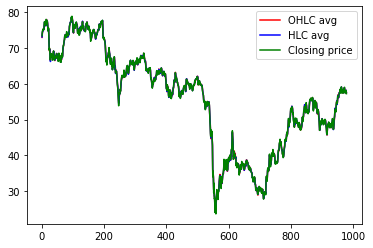

In [30]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [31]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)


In [32]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [33]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)

In [34]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [35]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [36]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
731/731 - 4s - loss: 0.0386 - 4s/epoch - 5ms/step
Epoch 2/5
731/731 - 1s - loss: 7.5791e-04 - 1s/epoch - 2ms/step
Epoch 3/5
731/731 - 1s - loss: 6.0574e-04 - 1s/epoch - 2ms/step
Epoch 4/5
731/731 - 1s - loss: 4.6260e-04 - 1s/epoch - 2ms/step
Epoch 5/5
731/731 - 1s - loss: 4.0173e-04 - 1s/epoch - 2ms/step


In [37]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [38]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [39]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.08


In [40]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))


Test RMSE: 1.40


In [41]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [42]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [43]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

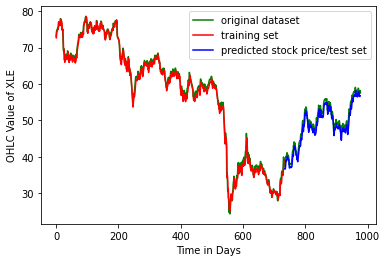

In [44]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of XLE')
plt.show()


In [45]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
# print np.append(last_val, next_val)


In [46]:
"Last Day Value:", last_val.item()

('Last Day Value:', 56.78744125366211)

In [47]:
"Next Day Value:", (last_val*next_val).item()

('Next Day Value:', 56.61970138549805)